# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, avg, stddev, split, isnull, isnan, first, when, last 
from pyspark.sql.functions import col, format_number, rand, countDistinct, count, desc
from pyspark.sql.functions import to_timestamp, lit
from pyspark.sql.functions import sum as s_sum
from pyspark.sql.functions import max as s_max
from pyspark.sql.functions import min as s_min
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, Imputer

import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import datetime

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify_Data") \
    .getOrCreate()

/usr/local/lib/python3.6/dist-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


# A. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## 1. Load

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
len(df.columns)

18

In [5]:
df.count()

286500

There are 18 columns and 286,500 rows in our dataset. Among those columns, columns named `userId` and `sessionId` will play important role as the key.

## 2. Cleansing

From above `df.describe(userId).show()`, we could find that it's minimum value is little awkward. Let's find and delete NaNs and empty strings.

We saw 8,346 empty strings in `userId`, so let's delete these.

In [6]:
df_cleaned = df.filter(df['userId']!='')
df_cleaned.count()

278154

In [7]:
df_cleaned.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
del df

---

# B. Exploratory Data Analysis

We've done this in `Sparkify_1_ETL_and_EDA.ipynb`. Let's apply its result to do feature engineering.

- Define `churn`

In [9]:
churn_users = df_cleaned.filter(df_cleaned.page == "Cancellation Confirmation") \
                .select("userId").dropDuplicates().collect()
churn_user_lst = [str(row.userId) for row in churn_users]

In [10]:
df_cln_stmp = df_cleaned.withColumn('churn', 
                                    when(df_cleaned.userId.isin(churn_user_lst), 1) \
                                    .otherwise(0))

- Change `ts` and `registration` into datetime variable

In [11]:
change_into_dt = udf(lambda x : datetime.datetime\
                                        .fromtimestamp(x/1000.0)\
                                        .strftime("%Y-%m-%d %H:%M:%S"))

df_cln_stmp = df_cln_stmp.withColumn('ts_dt', 
                                     change_into_dt(df_cln_stmp.ts))
df_cln_stmp = df_cln_stmp.withColumn('register_dt', 
                                     change_into_dt(df_cln_stmp.registration))

df_cln_stmp = df_cln_stmp.drop('ts').drop('registration')

- Drop columns we won't use

In [12]:
useless_cols = ['auth', 'method', 'firstName', 'lastName', 
                'userAgent', 'itemInSession', 'status']

df_cln_stmp = df_cln_stmp.select([col for col in df_cln_stmp.columns \
                                          if col not in useless_cols])

In [13]:
del df_cleaned

---

# C. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## C-1. From EDA

We'll start to make additional features related to some statistics of original columns from `df_cln_stmp`, as we saw in previous EDA section. The list is below.

- `Artist`  
    - Count of listened artists & distinct artists 
- `gender`  
- `length`
    - Total length of played songs, by second  
- `level`
    - Last status of level (free or paid)
- `page`  
    - Frequency of every values
- `song`
    - Count of played songs & distinct songs
- `sessionId`
    - The number of session each user played

- Artist

In [14]:
artist_cnt = df_cln_stmp.filter(df_cln_stmp.page == 'NextSong') \
                        .groupby(['userId']) \
                        .agg(count('artist').alias('artist_cnt'),
                             countDistinct('artist').alias('artist_cnt_uniq'))

**We'll make `df_final` for gather these features.**

In [15]:
df_final = artist_cnt
del artist_cnt

- gender 

We just used `.agg` for get `gender` column.

In [16]:
gender = df_cln_stmp.groupby(['gender','userId']) \
                    .agg({'churn':'count'}).drop('count(churn)')

df_final = df_final.join(gender,['userId'])

- length

In [17]:
length_sum = df_cln_stmp.filter(df_cln_stmp.page=='NextSong') \
                        .groupby(['userId']).agg(s_sum('length').alias('length_sum'))

df_final = df_final.join(length_sum,['userId'])

- level

In [18]:
level_last = df_cln_stmp.groupby(['userId']).agg(last('level').alias('level_last'))

df_final = df_final.join(level_last,['userId'])

- page

In [19]:
#Make pivot table of page
page_pivot = df_cln_stmp.groupby(['userId','churn']).pivot('page').count()
page_pivot = page_pivot.drop('Cancel').drop('Cancellation Confirmation')
page_pivot = page_pivot.fillna(0)

In [20]:
#Merge page count values per users
page_cnt = df_cln_stmp.filter("page!='Cancellation Confirmation' and page!='Cancel'\
                             and page!='Add Friend' \
                             and page!='Submit Downgrade' and page!='Submit Upgrade'")\
                          .groupBy('userId').count()

page_pivot = page_pivot.join(page_cnt, ['userId'])
page_pivot = page_pivot.withColumnRenamed('count', 'pageCount')

In [21]:
#Make frequancy columns
remain_cols = ['userId', 'churn', 'Add Friend', 
               'Submit Downgrade','Submit Upgrade', 'pageCount']
freq_cols = []

for col in page_pivot.columns:
    if col not in remain_cols:
        # add frequency col
        new_name = f'freq{col}'
        freq_cols.append(new_name)
        page_pivot = page_pivot.withColumn(new_name,
                                          page_pivot[col]/page_pivot['pageCount'])
        
page_pivot = page_pivot.select(remain_cols + freq_cols)

In [22]:
#Merge to df_final
df_final = df_final.join(page_pivot,['userId'])

- song

In [23]:
song_cnt = df_cln_stmp.filter(df_cln_stmp.page == 'NextSong') \
                    .groupby(['userId']) \
                    .agg(count('song').alias('song_cnt'),
                         countDistinct('song').alias('song_cnt_uniq'))

df_final = df_final.join(song_cnt, ['userId'])

- sessionId

In [24]:
session_cnt = df_cln_stmp.groupby(['userId']) \
                        .agg(countDistinct('sessionId').alias('session_cnt_uniq'))

df_final = df_final.join(session_cnt, ['userId'])

Let's see our data before jump into next step.

In [25]:
n_churns = df_final.filter(df_final.churn==1).select('userId').dropDuplicates().count()
n_users  = df_final.select('userId').dropDuplicates().count()

print(f'The number of users: {n_users}')
print(f'----- Churns: {n_churns}')
print(f'----- Others: {n_users - n_churns}')
print(f'Ratio: {round(100*n_churns/n_users, 2)}%')

The number of users: 225
----- Churns: 52
----- Others: 173
Ratio: 23.11%


Delete older things for our memory.

In [26]:
del gender, length_sum, level_last, page_pivot, song_cnt, session_cnt

## C-2. New Features

We'll add additional featrues, based on our data wrangling experiences. The list is below. 
- Average of the number of songs per each session
- Average duration of each session
- Average duration of each session INTERVAL by days
- Subscription length, calculated by registration date
- Ratio of same artists among whole artists user listened

To simplify, we'll use `ses` as an abbreviation of session.

- Average of the number of songs per each session

In [27]:
song_cnt_all_ses = df_cln_stmp.groupby(['userId', 'sessionId']) \
                            .agg(count('song').alias('song_cnt'))

song_cnt_per_ses = song_cnt_all_ses.groupby('userId') \
                                .agg(avg('song_cnt').alias('song_cnt_avg'))
song_cnt_per_ses.show(5)

+------+------------------+
|userId|      song_cnt_avg|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124| 140.6551724137931|
+------+------------------+
only showing top 5 rows



- Average duration of each session

In [28]:
ses_len = df_cln_stmp.groupby(['userId', 'churn', 'sessionId']) \
                    .agg(s_min('ts_dt'), s_max('ts_dt'))

ses_len = ses_len.select('userId', 'sessionId',
              to_timestamp('min(ts_dt)', 'yyyy-MM-dd HH:mm:ss').alias('min_ts_dt'),
              to_timestamp('max(ts_dt)', 'yyyy-MM-dd HH:mm:ss').alias('max_ts_dt'))

ses_len = ses_len.withColumn('ses_duration', 
                             (ses_len['max_ts_dt'].cast('long') \
                              -ses_len['min_ts_dt'].cast('long'))/60)

ses_len = ses_len.groupby('userId') \
                    .agg(avg('ses_duration').alias('avg_ses_duration'))
ses_len.printSchema()

root
 |-- userId: string (nullable = true)
 |-- avg_ses_duration: double (nullable = true)



- Average duration of each session **INTERVAL** by days

In [29]:
ses_interval = df_cln_stmp.groupby('userId') \
                    .agg(s_min('ts_dt'), s_max('ts_dt'), 
                         countDistinct('sessionId').alias('ses_cnt_uniq'))

ses_interval = ses_interval.select('userId', 'ses_cnt_uniq',
                    to_timestamp('min(ts_dt)', 'yyyy-MM-dd HH:mm:ss').alias('min_ts_dt'),
                    to_timestamp('max(ts_dt)', 'yyyy-MM-dd HH:mm:ss').alias('max_ts_dt'))

ses_interval = ses_interval.withColumn('ses_duration_total',
                                   (ses_interval['max_ts_dt'].cast('long') \
                                      -ses_interval['min_ts_dt'].cast('long'))/(24*60*60))

ses_interval = ses_interval.withColumn('avg_ses_dur_interval',
                                    ses_interval['ses_duration_total'] / ses_interval['ses_cnt_uniq'])

ses_interval = ses_interval.select(['userId', 'avg_ses_dur_interval'])
ses_interval.printSchema()

root
 |-- userId: string (nullable = true)
 |-- avg_ses_dur_interval: double (nullable = true)



- Subscription length, calculated by registration date

In [30]:
subs_len = df_cln_stmp.groupby('userId', 'register_dt') \
                        .agg(s_max('ts_dt'))

subs_len = subs_len.select('userId',
            to_timestamp('register_dt', 'yyyy-MM-dd HH:mm:ss').alias('register_dt'),
            to_timestamp('max(ts_dt)', 'yyyy-MM-dd HH:mm:ss').alias('max_ts_dt'))

subs_len = subs_len.withColumn('sub_len', 
                              (subs_len['max_ts_dt'].cast('long') \
                                  -subs_len['register_dt'].cast('long'))/(24*60*60))

subs_len = subs_len.select(['userId', 'sub_len'])
subs_len.printSchema()

root
 |-- userId: string (nullable = true)
 |-- sub_len: double (nullable = true)



- Ratio of same artists among whole artists user listened

In [31]:
df_final_2 = df_final.withColumn('same_artist_ratio',
                          df_final['artist_cnt_uniq'] / df_final['artist_cnt'])

Now add these new features to `df_final`.

In [32]:
df_final_2 = df_final_2.join(song_cnt_per_ses, 'userId')
df_final_2 = df_final_2.join(ses_len, 'userId')
df_final_2 = df_final_2.join(ses_interval, 'userId')
df_final_2 = df_final_2.join(subs_len, 'userId')

Delete older things for our memory.

In [33]:
del df_cln_stmp, df_final, song_cnt_per_ses, ses_len, ses_interval, subs_len

## C-3. Check Multicollinearity

We'll check the multicollinearity of features. Before I did this job, I used `toPandas()` first, but it takes about **3 hours**! Because this took too much time, I tried other method using `VectorAssembler()`. This was very much faster than before.

In [34]:
# Convert to vector column first
vector_col = "corr_features"
input_cols = [col for col in df_final_2.columns if col not in['userId', 'gender', 'level_last']]

assembler = VectorAssembler(inputCols=input_cols, outputCol=vector_col)
df_vector = assembler.transform(df_final_2).select(vector_col)

# Get correlation matrix
cor_mat = Correlation.corr(df_vector, vector_col)
cor_mat_1d_array = cor_mat.collect()[0]["pearson({})".format(vector_col)].values
cor_mat_2d_array = cor_mat_1d_array.reshape([len(input_cols), len(input_cols)])
cor_mat_df = pd.DataFrame(cor_mat_2d_array, index = input_cols, columns = input_cols)

/usr/local/lib/python3.6/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


<AxesSubplot:>

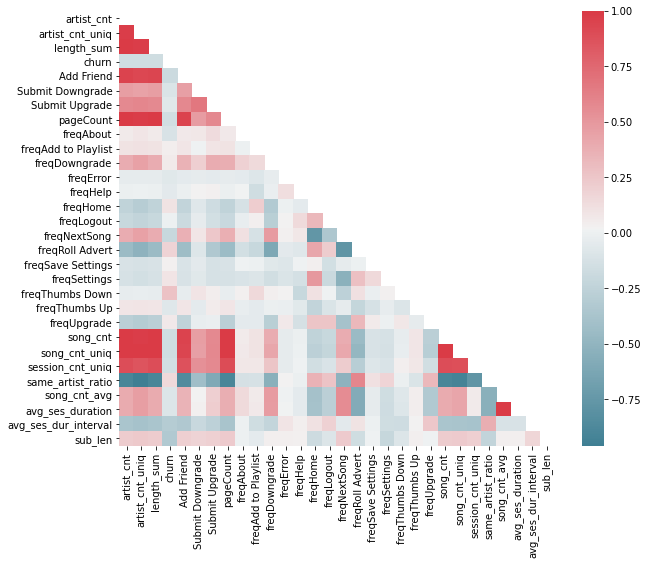

In [35]:
f, ax = plt.subplots(figsize=(10, 8))

# Use lower triangle only
mask = np.zeros_like(cor_mat_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(cor_mat_df, 
                    mask=mask,
                    cmap=sns.diverging_palette(220, 10, as_cmap=True),
                    square=True, ax=ax)

Let's find highly correlated columns among those.

In [36]:
# Create a True/False mask and apply it
cor_abs = cor_mat_df.abs()

mask = np.triu(np.ones_like(cor_abs, dtype=bool))
tri_df = cor_abs.mask(mask)

# List column names of highly correlated features (r > 0.95)
cols_to_drop = [col for col in tri_df.columns if any(tri_df[col] > 0.95)]

cols_to_drop

['artist_cnt',
 'artist_cnt_uniq',
 'length_sum',
 'pageCount',
 'song_cnt',
 'song_cnt_avg']

We'll drop those `cols_to_drop` and find again.

In [37]:
cor_abs_2 = cor_abs.drop(cols_to_drop, axis=0).drop(cols_to_drop, axis=1)

mask = np.triu(np.ones_like(cor_abs_2, dtype=bool))
tri_df = cor_abs_2.mask(mask)

# List column names of highly correlated features (r > 0.95)
cols_to_drop_2 = [col for col in tri_df.columns if any(tri_df[col] > 0.95)]

cols_to_drop_2

[]

Now we could say that we treated highly correlated columns.

We'll also drop those `cols_to_drop` in our original dataset, `df_final_2`.

In [38]:
df_final_3 = df_final_2.select([col for col in df_final_2.columns if col not in cols_to_drop])
# df_final_3.printSchema()

Next, we should drop `userId` and encode categorical features(`gender`, `level_last`) using `StringIndexer`.

In [39]:
#Drop userId
df_final_3 = df_final_3.drop('userId')

#Label encodling
label_encoder = StringIndexer(inputCol = 'gender', outputCol = 'gender_label')
df_final_3 = label_encoder.fit(df_final_3).transform(df_final_3); df_final_3 = df_final_3.drop('gender')

label_encoder = StringIndexer(inputCol = 'level_last', outputCol = 'level_last_label')
df_final_3 = label_encoder.fit(df_final_3).transform(df_final_3); df_final_3 = df_final_3.drop('level_last')

df_final_3.printSchema()

root
 |-- churn: integer (nullable = false)
 |-- Add Friend: long (nullable = true)
 |-- Submit Downgrade: long (nullable = true)
 |-- Submit Upgrade: long (nullable = true)
 |-- freqAbout: double (nullable = true)
 |-- freqAdd to Playlist: double (nullable = true)
 |-- freqDowngrade: double (nullable = true)
 |-- freqError: double (nullable = true)
 |-- freqHelp: double (nullable = true)
 |-- freqHome: double (nullable = true)
 |-- freqLogout: double (nullable = true)
 |-- freqNextSong: double (nullable = true)
 |-- freqRoll Advert: double (nullable = true)
 |-- freqSave Settings: double (nullable = true)
 |-- freqSettings: double (nullable = true)
 |-- freqThumbs Down: double (nullable = true)
 |-- freqThumbs Up: double (nullable = true)
 |-- freqUpgrade: double (nullable = true)
 |-- song_cnt_uniq: long (nullable = false)
 |-- session_cnt_uniq: long (nullable = false)
 |-- same_artist_ratio: double (nullable = true)
 |-- avg_ses_duration: double (nullable = true)
 |-- avg_ses_dur_in

# D. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

**Since the ratio of churn users in our dataset is almost 23%, we'd rather use F-1 score than accuracy.** Because the minimum accuracy would be 77%!

In [40]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

Before starting task, we'll delete older things because of memory.

In [41]:
del df_final_2, cor_mat, cor_mat_1d_array, cor_mat_2d_array, cor_mat_df

## D-1. Fill null values

In [42]:
df_final_3.select([count(when(isnan(col), col)).alias(col) for col in df_final_3.columns]) \
            .toPandas().unstack()

churn                 0    0
Add Friend            0    0
Submit Downgrade      0    0
Submit Upgrade        0    0
freqAbout             0    0
freqAdd to Playlist   0    0
freqDowngrade         0    0
freqError             0    0
freqHelp              0    0
freqHome              0    0
freqLogout            0    0
freqNextSong          0    0
freqRoll Advert       0    0
freqSave Settings     0    0
freqSettings          0    0
freqThumbs Down       0    0
freqThumbs Up         0    0
freqUpgrade           0    0
song_cnt_uniq         0    0
session_cnt_uniq      0    0
same_artist_ratio     0    0
avg_ses_duration      0    0
avg_ses_dur_interval  0    0
sub_len               0    0
gender_label          0    0
level_last_label      0    0
dtype: int64

There's no null values in our dataset. If there's any null values, we could use `Imputer` to impute these.

## D-2. Build default model and evaluate

In [43]:
def eval_model(pred_val, pred_test):
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol=y_col)
    
    f1_val = evaluator.evaluate(pred_val, {evaluator.metricName: 'f1'})
    ac_val = evaluator.evaluate(pred_val, {evaluator.metricName: 'accuracy'})
    
    f1_test = evaluator.evaluate(pred_test, {evaluator.metricName: 'f1'})
    ac_test = evaluator.evaluate(pred_test, {evaluator.metricName: 'accuracy'})
    
    eval_series = pd.Series({'F1_Val': f1_val, 
                                        'Accuracy_Val': ac_val,
                                        'F1_Test': f1_test,
                                        'Accuracy_Test' :ac_test })
    
    return eval_series

In [44]:
seed = 1077

X_col = [col for col in df_final_3.columns if col!='churn']
y_col = 'churn'

We'll build the pipeline `pipeline_1` for preprocessing.

In [45]:
vec_assembler = VectorAssembler(inputCols=X_col, outputCol='features')
scaler = MinMaxScaler(inputCol='features', outputCol='features_scaled')

pipeline_1 = Pipeline(stages = [vec_assembler, scaler]) # for preprocessing

input_df = pipeline_1.fit(df_final_3).transform(df_final_3)

# Split data into train+val and test
train_temp, test = input_df.randomSplit([.8, .2], seed=seed)

# Split train into train and val
train, val = train_temp.randomSplit([.8, .2], seed=seed)

Because of our memory, we'll try `LogisticRegression`, `RandomForestClassifier`, `GBTClassifier` for our dataset with default settings chunk by chunk.

In [46]:
%%time

lr = LogisticRegression(labelCol=y_col, featuresCol='features_scaled')

model_lr = lr.fit(train)
pred_lr_val = model_lr.transform(val)
pred_lr_test = model_lr.transform(test)

eval_lr = eval_model(pred_lr_val, pred_lr_test)

CPU times: user 171 ms, sys: 82.9 ms, total: 254 ms
Wall time: 1min 34s


In [47]:
%%time

rf = RandomForestClassifier(labelCol=y_col, featuresCol='features_scaled')

model_rf = rf.fit(train)
pred_rf_val = model_rf.transform(val)
pred_rf_test = model_rf.transform(test)

eval_rf = eval_model(pred_rf_val, pred_rf_test)

CPU times: user 186 ms, sys: 86.3 ms, total: 273 ms
Wall time: 1min 44s


In [48]:
%%time

gbt = GBTClassifier(labelCol=y_col, featuresCol='features_scaled')

model_gbt = gbt.fit(train)
pred_gbt_val = model_gbt.transform(val)
pred_gbt_test = model_gbt.transform(test)

eval_gbt = eval_model(pred_gbt_val, pred_gbt_test)

CPU times: user 179 ms, sys: 77.6 ms, total: 256 ms
Wall time: 1min 10s


**Since spark session keep being disconnected because of memory, we saved the result of default model evaluation as `eval_default_result.pkl`.**

In [49]:
eval_default_result = pd.concat([eval_lr.rename('LogisticRegression'),
                                                  eval_rf.rename('RandomForest'),
                                                  eval_gbt.rename('GradientBoosting')], axis=1)

# save
with open('eval_default_result.pkl', 'wb') as f:
    pickle.dump(eval_default_result, f, pickle.HIGHEST_PROTOCOL)

In [50]:
# # load
# with open('eval_default_result.pkl', 'rb') as f:
#     eval_default_result = pickle.load(f)
    
eval_default_result

,LogisticRegression,RandomForest,GradientBoosting
F1_Val,0.772906,0.782828,0.732268
Accuracy_Val,0.787879,0.818182,0.757576
F1_Test,0.794132,0.707483,0.753720
Accuracy_Test,0.809524,0.761905,0.761905


**We can see that `LogisticRegression`'s F1 score is highest among three models. So we'll use this for our final output.**

In [54]:
model_lr.save('sparkify_logistic_ver1.pkl')

## D-3. Hyperparameter tuning (skipped)

**To sorrow, our memory couldn't handle this CV task. So we wrote the codes and commented out them.**

In [51]:
def create_CV(train, feature_cols, classifier, parameters):
    '''
    Create a cross validation object and return a trained model
    
    - Input
    train: training dataset
    feature_cols: column names of dataset (X_col in this notebook)
    classifier: spark ml classification algorithm
    paramaters: parameter list for grid search
    
    - Output
    cv_fitted: train-fitted cv model
    '''

    model = CrossValidator(
        estimator=classifier,
        estimatorParamMaps=parameters,
        evaluator = MulticlassClassificationEvaluator(labelCol=y_col,
                                                                                metricName='f1'),
                                                                                numFolds=3)
    cv_fitted = model.fit(train)
    
    return cv_fitted

In [52]:
# %%time 

## Get best model via CV task

# lr = LogisticRegression(labelCol=y_col, featuresCol='features_scaled')
# param_grid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1, 1.0, 10.0]) \
#                                                     .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()

# model_lr_best = create_CV(train, X_col, lr, param_grid)

In [53]:
## Get metrics of our best model

# pred_best_lr_val = model_lr_best.transform(val)
# pred_best_lr_test = model_lr_best.transform(test)

# eval_best_lr = eval_model(pred_best_lr_val, pred_best_lr_test)
# print(eval_best_lr)

## D-4. See feature importance

In [60]:
model_lr.coefficients

DenseVector([-3.1385, 1.7383, -2.9929, -5.859, -3.071, 4.6552, -5.7142, 0.8973, 3.7607, -1.2649, -5.0575, 3.7748, 2.86, -11.1971, 10.3566, 2.0163, 2.6417, -8.3102, -28.5643, -10.0754, -9.3514, -22.0573, -7.1193, 0.0842, -4.5277])

In [61]:
fi_df = pd.DataFrame()
fi_df['feature'] = X_col
fi_df['importance'] = model_lr.coefficients.values

fi_df = fi_df.sort_values(by = 'importance', ascending = False).reset_index(drop=True)
fi_df

,feature,importance
0,freqThumbs Down,10.356577
1,freqDowngrade,4.655152
2,freqRoll Advert,3.774832
3,freqHome,3.760709
4,freqSave Settings,2.859969
5,freqUpgrade,2.641740
6,freqThumbs Up,2.016255
7,Submit Downgrade,1.738344
8,freqHelp,0.897338
9,gender_label,0.084201


We could see that `freqThumbs Down`, `freqDowngrade`, `freqRoll Advert` and `freqHome` have a large effect on whether user become churn or not. This seems quite make sense because these values related to user's dissatisfaction.

# E. Findings & Conclusion

We built a churn detecting model with small-medium sized event data. If we could predict whether user will quit our service or not, we could treat these users with various remedies before they quit. (ex: give them coupons or send them event push alarm, etc)

Because of lack of computing power, we couldn't do cross validation for obtaining best model. If our computing power is much stronger than now, we could use more various models and various techniques(ensemble method like stacking, etc) to get best predictions.

# F. Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.